In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from pyspark.mllib.stat import Statistics
%matplotlib inline

import findspark
findspark.init()

# Import and start a Spark session.
from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType

spark = SparkSession.builder.getOrCreate()
plt.rcParams['figure.figsize'] = [12, 8]

# Analyze of hashtags as a whole

The first part of our work is the analysis of how hashtags behave. Here, we want to understand the general behavior. A more precise analyse on specific hashtags will come latter.

## Creating our datasets

As the twitter dataset is huge, we can't work directly on it, we must find a way to extract insights from it that are usefull from our analysis. We are particularly interested in two metrics: 
- the count of tweets having a given hashtag
- the exposure (which we are calling "print") of tweets having a given hashtag. The exposure of a tweet is defined as an approximation of the audience reached by it, which is approximately the number of followers of the author. Then, we can approximate the exposure of several tweets by the sums of the followers of every authors. This is an over approximation as some users could have common followers, but it should be good enough.

Then, for each hashtag $h$ we are extracting the following insights:
- the total count of tweets having the hashtag $h$
- for each day the total count of tweets having the hashtag $h$ and tweeted on this day
- the exposure of tweets having the hashtag $h$
- for each day the exposure of tweets having the hashtag $h$ and tweeted on this day

More concretely, we ran the script `hashtag_insights.py` for each month on the cluster. Then, we merged the insights of different months as explained below.

### Merging of monthly insights into an insights dataframe.

We start by loading our monthly insights extracted from the cluster. We load every month of 2017 at the exception of:
- January, as we never managed to open it on the cluster
- June, as it contain nearly no data on the cluster
- December as it was absent of the cluster

In [26]:
def load_insights(months):
    return {month: spark.read.parquet('hashtags_insights_{}.parquet'.format(month)) for month in months} 

hashtags = load_insights(['02', '03', '04', '05', '07', '08', '09', '10', '11'])

For reasons we didn't understood, our hashtags insights for the month of augusts contained some duplicates rows. Hence, we remove them before continuing our analysis.

In [ ]:
hashtags['08'] = hashtags['08'].dropDuplicates()

For each monthly hashtags, some days could be absent (which is the case for the month of November where the 19th, 20th, 21st, 22nd, 23rd, 24th and 25th are missing). We remove the corresponding rows. For rows that still exists we prefix them. As rows `count` and `print` can be recomputed easily, to avoid any conflicts when joining the monthly insights we remove them.

In [ ]:
def rename_columns(insights, prefix):
    printCols = [c for c in insights.columns if "print_" in c]
    nameCols = [c for c in insights.columns if "count_" in c]
    print(insights, prefix)
    for x in printCols + nameCols:
        if insights.where(F.col(x) != 0).count() == 0:
            insights = insights.drop(x)
        else:
            insights = insights.withColumnRenamed(x, prefix + "_" + x)
    return insights.drop("count").drop("print")

In [ ]:
insights = [rename_columns(hashtags[key], key) for key in hashtags]

We now join every monthly hashtags by using an outer join.

In [ ]:
from functools import reduce

def joinAll(dfs):
    return reduce(lambda prev, cur: cur.join(prev, on='tag', how='outer'), dfs)

In [ ]:
unifiedInsights = joinAll(insights)

We then replace Nan entries by 0 and we recompute rows `count` and `print`.

In [ ]:
unifiedInsights = unifiedInsights.fillna(0).cache()
count_columns = [c for c in unifiedInsights.columns if "count" in c]
unifiedInsights = unifiedInsights.withColumn("count", sum(F.col(c) for c in count_columns))
print_columns = [c for c in unifiedInsights.columns if "print" in c]
unifiedInsights = unifiedInsights.withColumn("print", sum(F.col(c) for c in print_columns))

Finally we export this dataset to a parquet file.

In [ ]:
unifiedInsights.write.mode("overwrite").parquet("hashtags-insights.parquet")

### Building a "compressed insights" from our insights.

For convenience, we also decided to build a new dataset from the previous one. The main difference is in how we store the count per day and the print per day. In the previous dataset we had one column per day for the count and the exposure. In the one we will be building, we will have a row which will be an array of counts, and a row which will be an array of exposure (the ith entry maps to day i). These arrays will be relative to the row count and print, that is normalized between 0 and 1. This allows us to compare the behavior of two hashtags more accurately.

In [2]:
insights = spark.read.parquet("hashtags-insights.parquet")

We first build a time-sorted list of names of columns corresponding to a hashtag count. We also build the equivalent for the exposure.

In [3]:
def key(c):
    """ Parse a column name of the form month_(print|count)_day in a tuple (month, day)"""
    month, _, day = c.split("_")
    return int(month), int(day)


count_columns_wkey = [(c, key(c)) for c in insights.columns if "count_" in c]
count_columns_wkey.sort(key=lambda x: x[1])
count_columns = [a for a, _ in count_columns_wkey]
count_days = [b for _, b in count_columns_wkey]

print_columns_wkey = [(c, key(c)) for c in insights.columns if "print_" in c]
print_columns_wkey.sort(key=lambda x: x[1])
print_columns = [a for a, _ in print_columns_wkey]
print_days = [b for _, b in print_columns_wkey]

We create a new column `count_daily` which will be the array of normalized daily counts and drop the columns that have become useless.

In [ ]:
insights_compressed = \
    insights \
    .withColumn("count_daily", F.array(*[F.col(c) / F.col('count') for c in count_columns])) \
    .select(*[c for c in insights_compressed.columns if not c in count_columns])

We know do the same to add `print_daily`, which is the equivalent of `count_daily` but for the exposure.

In [ ]:
insights_compressed = \
    insights_compressed \
    .withColumn("print_daily", F.array(*[F.col(c) / F.col('print') for c in print_columns])) \
    .select(*[c for c in insights_compressed.columns if not c in print_columns])

Then we export the resulting dataset to a parquet file.

In [ ]:
insights_compressed.write.parquet("insights-compressed.parquet")

## Analysis of hashtags insight

We start by loading our two datasets:

In [2]:
insights = spark.read.parquet("hashtags-insights.parquet")

In [3]:
insights_compressed = spark.read.parquet("insights-compressed.parquet")

### General statistics

We have around 15 million different hashtags in the dataset.

In [32]:
insights.count()

15177260

The average exposure is of 134 thousand people, while on average an hashtag appears 21 time in our dataset. Do not forget that we extracted the hashtags from a 1% sample of twitter, hence the truth is that the true average of the number of occurences is more likely to be around 2100.

In [34]:
insights.agg({"count": "avg", "print": "avg"}).show()

+------------------+------------------+
|        avg(print)|        avg(count)|
+------------------+------------------+
|134616.39214831925|21.220559969322526|
+------------------+------------------+



However, the average count, and even the average print are completly biased by the outliers. The median of the count is 1!

In [44]:
insights.approxQuantile('count', [.25, .5, .75], .001)

[1.0, 1.0, 3.0]

In [38]:
insights.approxQuantile('print', [.25, .5, .75], .001)

[143.0, 710.0, 3968.0]

In fact, only 38% of the hashtags are present more than once.

In [51]:
100 * float(insights.where(F.col('count') > 1).count()) / float(insights.count())

38.79508554244969

More surprisingly, .78% of hashtags are present at least 250 times. 

In [104]:
100 * float(insights.where(F.col('count') > 250).count()) / float(insights.count())

0.7877377075967599

Starting from now, we will pursue our analysis only on hashtags occuring more than 250 times: this a good compromise about "generality" and focusing on "viral" tweets.

In [77]:
THRESHOLD_COUNT = 250

The histogram of the number of occurences shows clearly that the number of occurences is sharply decreasing.
The noise at the start of the histogram might be due to the sampling: missing one tweet out of 50 is more impactfull than one tweet out of 250. 

In [95]:
bins, counts = insights.where(F.col('count') > 50) \
        .select(F.log10('count')).rdd \
        .flatMap(lambda x: x) \
        .histogram(150)

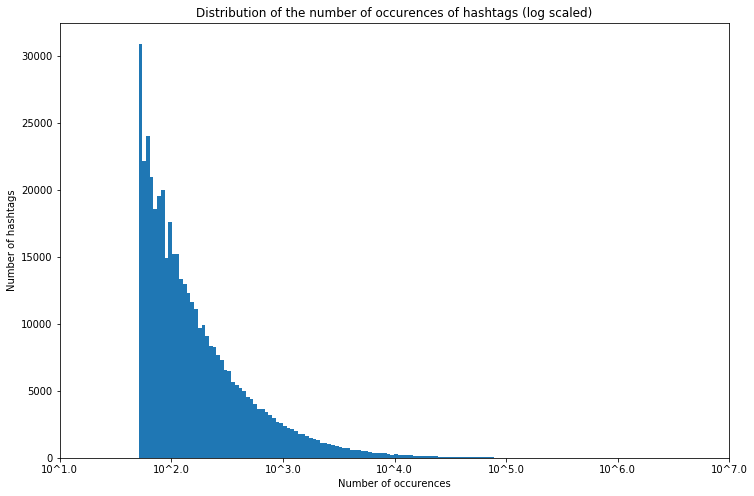

In [96]:
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.title('Distribution of the number of occurences of hashtags (log scaled)' )
plt.ylabel('Number of hashtags')
plt.xlabel('Number of occurences')
locs, _ = plt.xticks()
labels = ["10^{}".format(l) for l in locs]
plt.xticks(locs, labels);

In fact, it is even following a power-law:

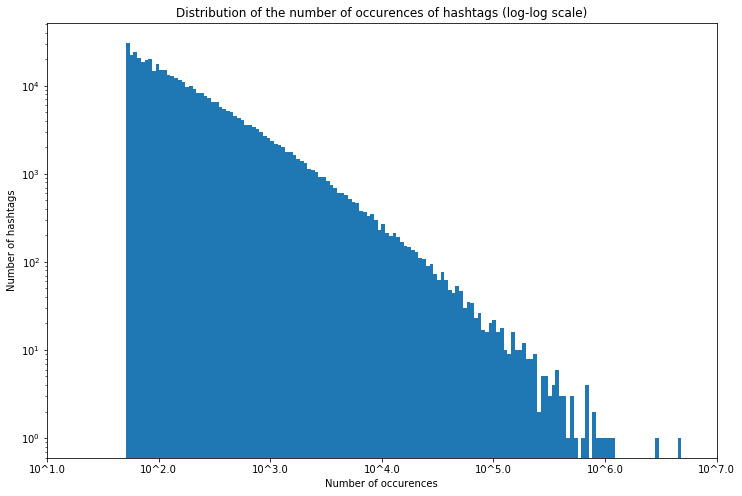

In [98]:
plt.hist(bins[:-1], bins=bins, weights=counts, log=True)
plt.title('Distribution of the number of occurences of hashtags (log-log scale)' )
plt.ylabel('Number of hashtags')
plt.xlabel('Number of occurences')
locs, _ = plt.xticks()
labels = ["10^{}".format(l) for l in locs]
plt.xticks(locs, labels);

In [117]:
100 * float(insights.where(F.col('print') > 1500000).count()) / float(insights.count())

0.8305451708674688

In [103]:
100 * float(insights.where(F.col('print') > 500000).count()) / float(insights.count())

1.83284729918312

In [105]:
bins, counts = insights.where(F.col('print') > 500000) \
        .select(F.log10('print')).rdd \
        .flatMap(lambda x: x) \
        .histogram(150)

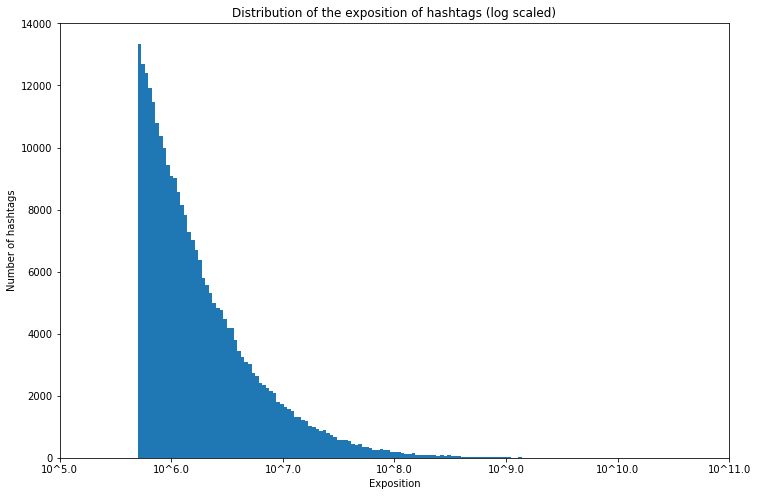

In [110]:
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.title('Distribution of the exposition of hashtags (log scaled)' )
plt.ylabel('Number of hashtags')
plt.xlabel('Exposition')
locs, _ = plt.xticks()
labels = ["10^{}".format(l) for l in locs]
plt.xticks(locs, labels);

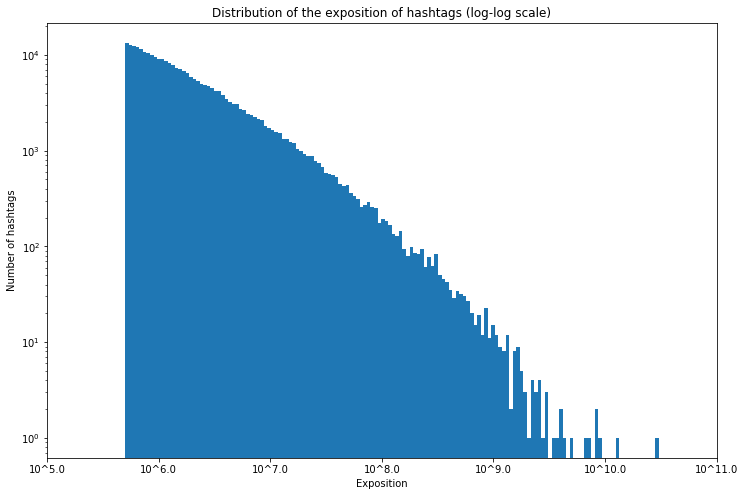

In [109]:
plt.hist(bins[:-1], bins=bins, weights=counts, log=True)
plt.title('Distribution of the exposition of hashtags (log-log scale)' )
plt.ylabel('Number of hashtags')
plt.xlabel('Exposition')
locs, _ = plt.xticks()
labels = ["10^{}".format(l) for l in locs]
plt.xticks(locs, labels);

In [142]:
insights_r = insights.where(F.col('count') > THRESHOLD_COUNT).cache()

In [143]:
features = insights_r.select("count", "print").rdd.map(lambda row: row[0:])
corr = Statistics.corr(features, method="spearman")

In [144]:
corr[0][1]

0.45635800425950807

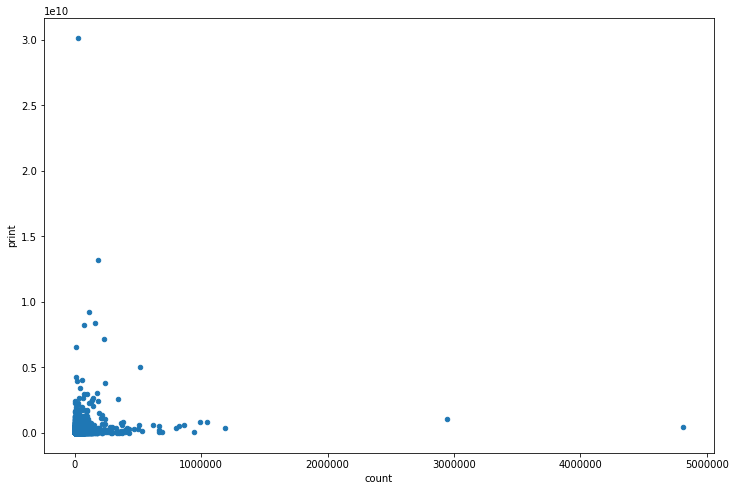

In [159]:
sample = insights_r.select("tag", "count", "print").toPandas()
sample.plot.scatter('count', 'print')

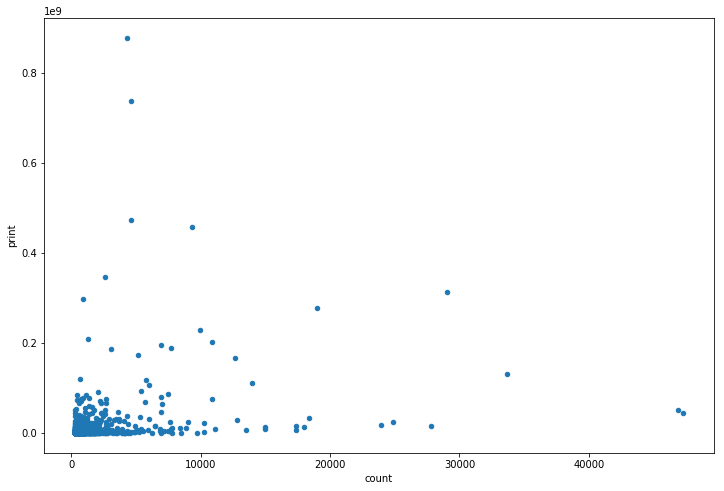

In [165]:
sample = insights_r.where((F.col('count') < 50000) & (F.col('print') < .1 * 1e10)).select("tag", "count", "print").sample(False, .01).toPandas()
sample.plot.scatter('count', 'print')

### Study of correlation between days

We know study the correlation of the number of tweets per day per hashtags. Intuitively, we might think that everyday has approximately the same nu

In [ ]:
We first plot the correlation matrix for the number of tweets per days

In [6]:
features = insights.where(F.col('count') > THRESHOLD_COUNT).select(count_columns).rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="spearman")

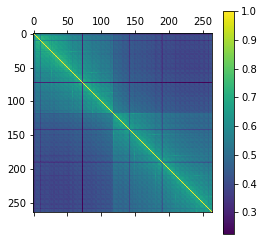

In [29]:
corr_df = pd.DataFrame(corr_mat)
ax = plt.matshow(corr_df)
plt.colorbar(ax)

In [37]:
features = insights.where(F.col('print') > 1500000).select(count_columns).rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="spearman")

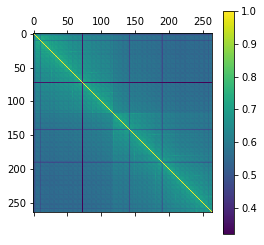

In [38]:
corr_df = pd.DataFrame(corr_mat)
ax = plt.matshow(corr_df)
plt.colorbar(ax)

In [39]:
count_days[118]

(7, 1)

In [44]:
insights.where(F.col('count') > 250).agg(*[F.sum(F.col(c)).alias(c) for c in count_columns]).show(vertical=True)

-RECORD 0--------------
 02_count_1  | 987403  
 02_count_2  | 938978  
 02_count_3  | 249162  
 02_count_5  | 772542  
 02_count_6  | 1143028 
 02_count_7  | 1095506 
 02_count_8  | 1078792 
 02_count_9  | 1083597 
 02_count_10 | 1013434 
 02_count_11 | 1023395 
 02_count_12 | 260172  
 02_count_13 | 314072  
 02_count_14 | 1041497 
 02_count_15 | 960805  
 02_count_16 | 956833  
 02_count_17 | 1003306 
 02_count_18 | 1051258 
 02_count_19 | 1081788 
 02_count_20 | 1001810 
 02_count_21 | 1016369 
 02_count_22 | 1104950 
 02_count_23 | 1060823 
 02_count_24 | 1090663 
 02_count_25 | 1058844 
 02_count_26 | 1028391 
 02_count_27 | 1086430 
 02_count_28 | 1002684 
 03_count_1  | 942305  
 03_count_2  | 1023506 
 03_count_3  | 999595  
 03_count_4  | 1063947 
 03_count_5  | 1170305 
 03_count_6  | 1128743 
 03_count_7  | 933377  
 03_count_8  | 1061935 
 03_count_9  | 957482  
 03_count_10 | 924831  
 03_count_11 | 934168  
 03_count_12 | 1006777 
 03_count_13 | 948103  
 03_count_14 | 9

In [49]:
sum_count_day_pd = insights.where(F.col('count') > 250).agg(*[F.sum(F.col(c)).alias(c) for c in count_columns]).toPandas()

In [58]:
sum_count_day_pd.head()

,02_count_1,02_count_2,02_count_3,02_count_5,02_count_6,02_count_7,02_count_8,02_count_9,02_count_10,02_count_11,...,11_count_14,11_count_15,11_count_16,11_count_17,11_count_18,11_count_26,11_count_27,11_count_28,11_count_29,11_count_30
0,987403,938978,249162,772542,1143028,1095506,1078792,1083597,1013434,1023395,...,802890,770297,784771,758761,520248,829367,1219880,714586,848704,683677


In [66]:
sum_count_day_pd.columns

Index([u'02_count_1', u'02_count_2', u'02_count_3', u'02_count_5',
       u'02_count_6', u'02_count_7', u'02_count_8', u'02_count_9',
       u'02_count_10', u'02_count_11',
       ...
       u'11_count_14', u'11_count_15', u'11_count_16', u'11_count_17',
       u'11_count_18', u'11_count_26', u'11_count_27', u'11_count_28',
       u'11_count_29', u'11_count_30'],
      dtype='object', length=264)

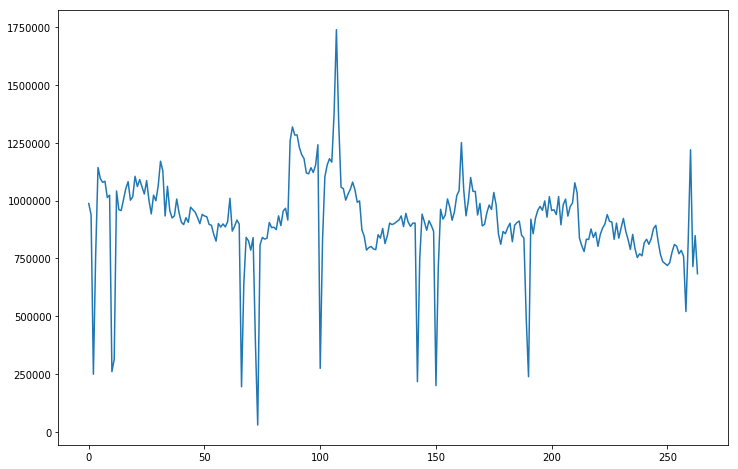

In [71]:
plt.plot( range(0, len(count_columns)), sum_count_day_pd.loc[0].values)

In [ ]:
plt.plot()

In [10]:
corr_mat=Statistics.corr(features, method="pearson")

In [12]:
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = count_columns, count_columns

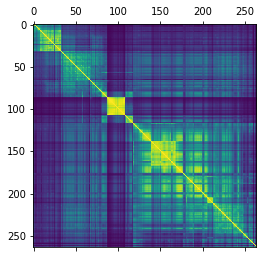

In [13]:
plt.matshow(corr_mat)

In [19]:
features = insights.where(F.col('count') > 100).select(count_columns).rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="spearman")

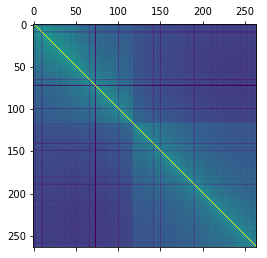

In [20]:
plt.matshow(corr_mat)

In [22]:
count_days[90:110]

[(5, 4),
 (5, 5),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (5, 15),
 (5, 16),
 (5, 17),
 (5, 18),
 (5, 19),
 (5, 20),
 (5, 21),
 (5, 22),
 (5, 23)]

In [ ]:
features = insights.where(F.col('print') > 100).select(print_columns).rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")

In [11]:
insights.count()

15177260

In [15]:
insights.where(F.col('count') > 1).count()

5888031

In [16]:
insights.where(F.col('count') > 100).count()

257434

In [17]:
bins, counts = insights.where(F.col('count') > 100) \
        .select(F.log10('count')).rdd \
        .flatMap(lambda x: x) \
        .histogram(100)

Text(0, 0.5, 'Number of occurences')

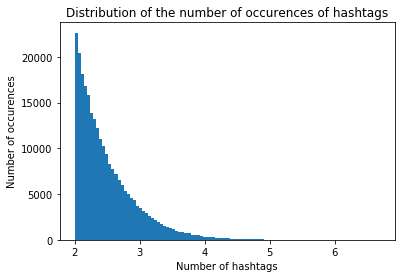

In [19]:
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.title('Distribution of the number of occurences of hashtags' )
plt.xlabel('Number of hashtags')
plt.ylabel('Number of occurences')

In [30]:
bins, counts = insights.where(F.col('print') > 1000) \
        .select(F.log10('print')).rdd \
        .flatMap(lambda x: x) \
        .histogram(100)

Text(0, 0.5, 'Number of occurences')

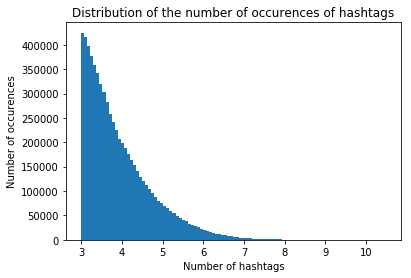

In [31]:
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.title('Distribution of the number of occurences of hashtags' )
plt.xlabel('Number of hashtags')
plt.ylabel('Number of occurences')

In [32]:
test = insights.where(F.col('count') > 100).toPandas()

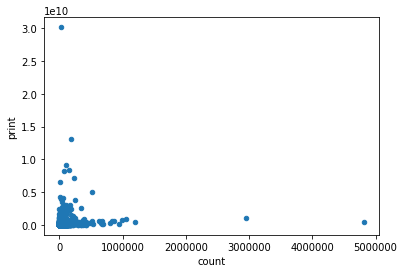

In [34]:
test.plot.scatter(x="count", y="print")

In [37]:
test.sort_values("count", ascending=False).head()

,tag,11_print_1,11_print_2,11_print_3,11_print_4,11_print_5,11_print_6,11_print_7,11_print_8,11_print_9,...,02_count_21,02_count_22,02_count_23,02_count_24,02_count_25,02_count_26,02_count_27,02_count_28,count,print
193708,izmirescort,683095,1173665,495435,449088,605584,305955,68561,41577,66398,...,4916,7339,5696,5451,4886,4517,5264,6686,4813484,473402849
181676,BTSBBMAs,313285,8747,286921,13567,253865,54084,12916,4770,8963,...,0,0,0,0,0,0,0,0,2943069,1054566200
181942,MTVHottest,48775,35054,44860,69997,41356,52917,29678,42271,34500,...,89,86,99,98,57,35,34,46,1188991,408684695
256291,BTS,4667800,2774639,6995572,4675435,1901820,2946446,1844329,2342752,1958604,...,2632,4931,6164,5951,4760,5391,4229,2911,1048438,856258406
253669,방탄소년단,5333705,3708412,6501709,5048843,3176814,3018128,1925205,2081661,1854240,...,3190,5655,11064,9037,7407,8583,4950,3238,992185,805900903


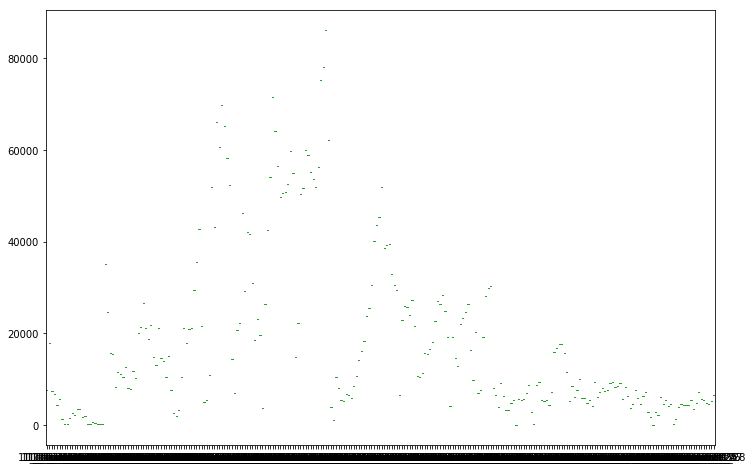

In [50]:
columns = [c for c in test.columns if "count_" in c]
test[test.tag=="izmirescort"].boxplot(columns, grid=False)

In [ ]:
insightsPd = insights.select(F.col('count') > 250).toPandas()

In [6]:
insightsPd.shape

NameError: name 'insightsPd' is not defined

In [47]:
sample_ic_pd = insights_compressed.where(F.col('count') > 250).sample(False, .005).toPandas()

In [48]:
sample_ic_pd.shape

(575, 5)

In [57]:
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering
from scipy.spatial.distance import pdist, squareform
from fastdtw import fastdtw

In [50]:
type(sample_ic_pd.count_daily.map(np.array).values[0])

numpy.ndarray

In [58]:
dist_matrix =\
    squareform(pdist(
        pd.DataFrame(sample_ic_pd.count_daily.values.tolist(), index=sample_ic_pd.index), 
        lambda a, b : fastdtw(a, b)[0]))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [59]:
dist_matrix

array([[0.        , 1.98220155, 1.8191492 , ..., 0.45558739, 1.26378366,
        0.31900036],
       [1.98220155, 0.        , 1.86532757, ..., 0.37769328, 1.90620814,
        2.        ],
       [1.8191492 , 1.86532757, 0.        , ..., 1.4739665 , 1.14529262,
        1.7275291 ],
       ...,
       [0.45558739, 0.37769328, 1.4739665 , ..., 0.        , 1.24888365,
        0.43033703],
       [1.26378366, 1.90620814, 1.14529262, ..., 1.24888365, 0.        ,
        1.31661992],
       [0.31900036, 2.        , 1.7275291 , ..., 0.43033703, 1.31661992,
        0.        ]])

In [85]:
def doAgglomerative(X, nclust=2):
    model = AgglomerativeClustering(n_clusters=nclust, affinity = 'precomputed', linkage = 'average')
    labels = model.fit_predict(X)
    return labels

labels = doAgglomerative(dist_matrix, 10)

In [86]:
clust_labels1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

/home/pierre/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


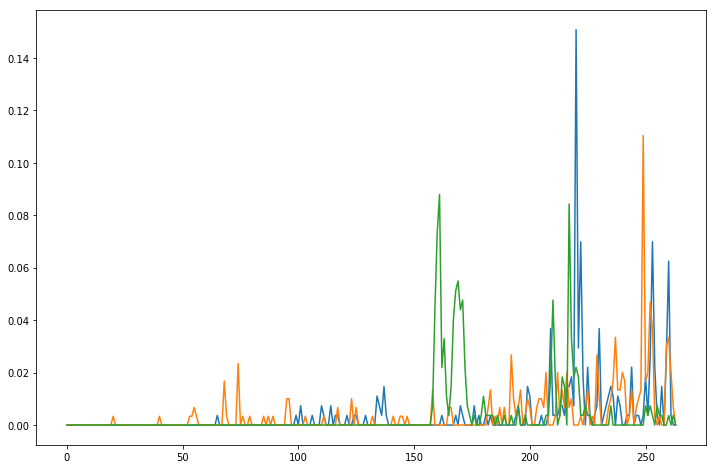

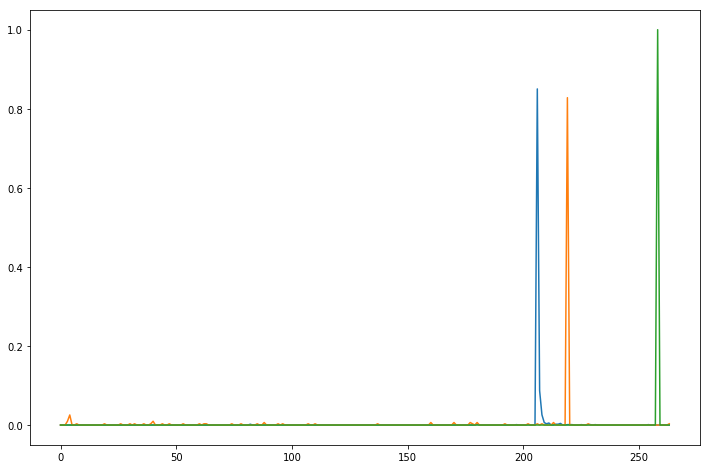

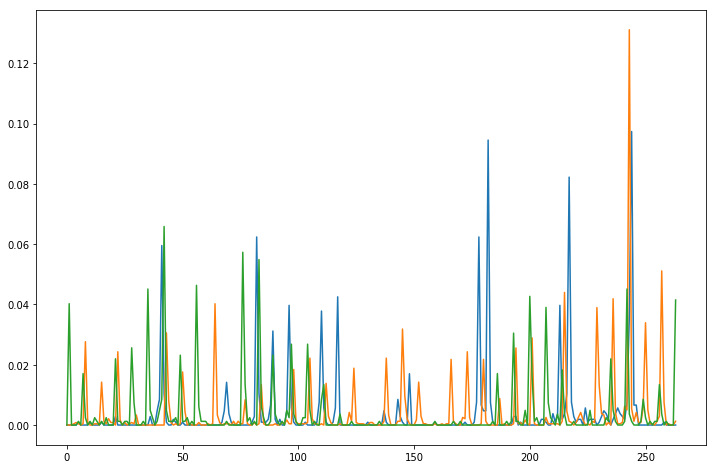

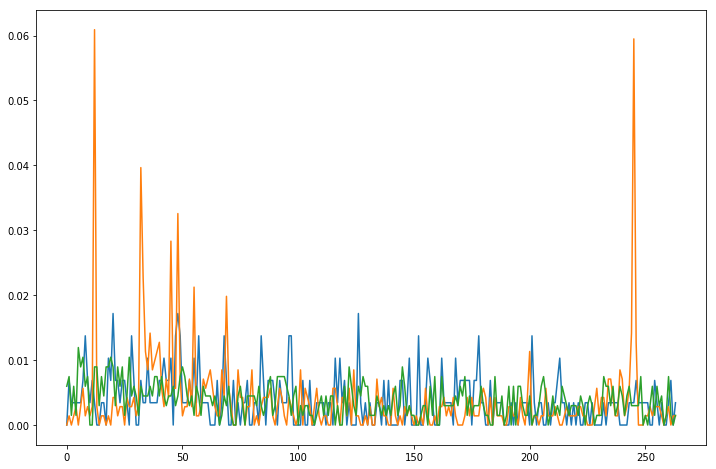

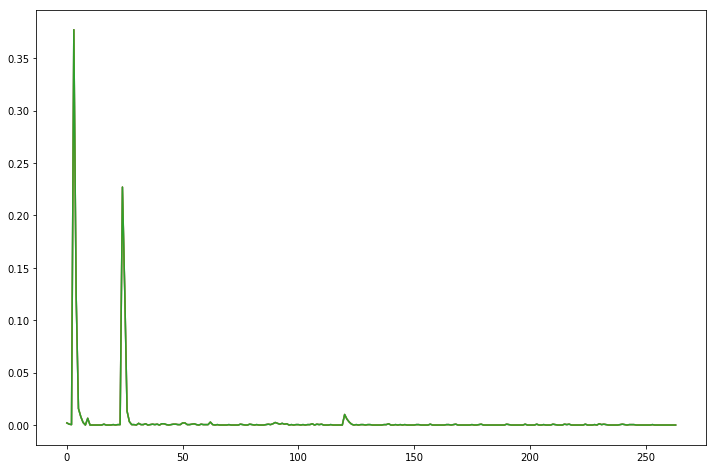

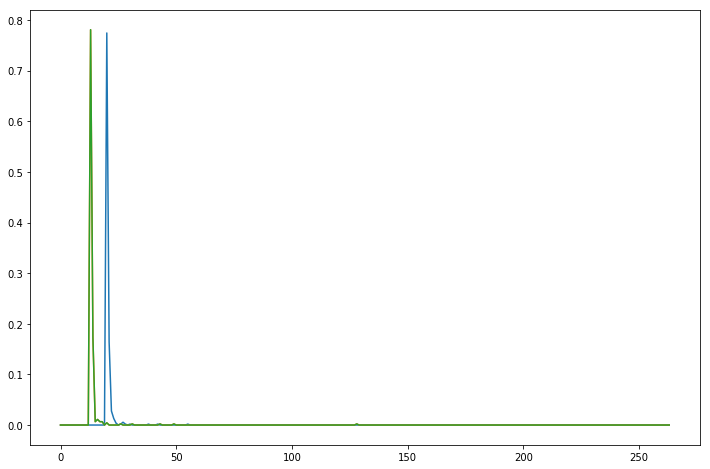

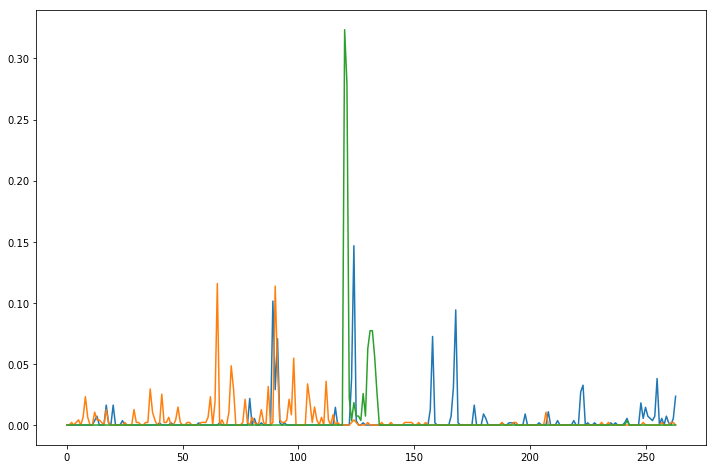

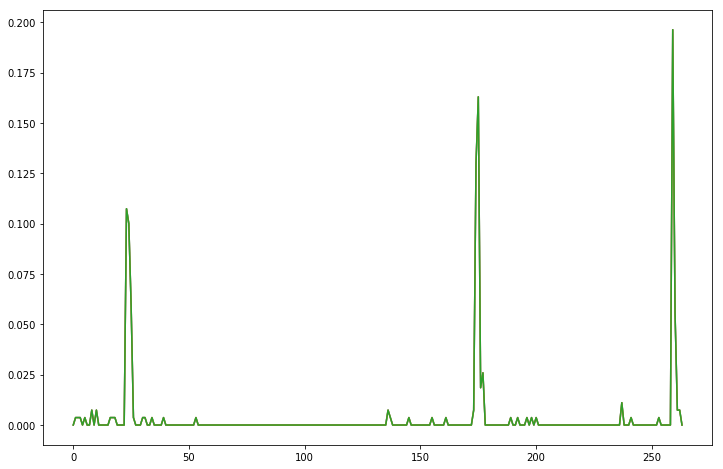

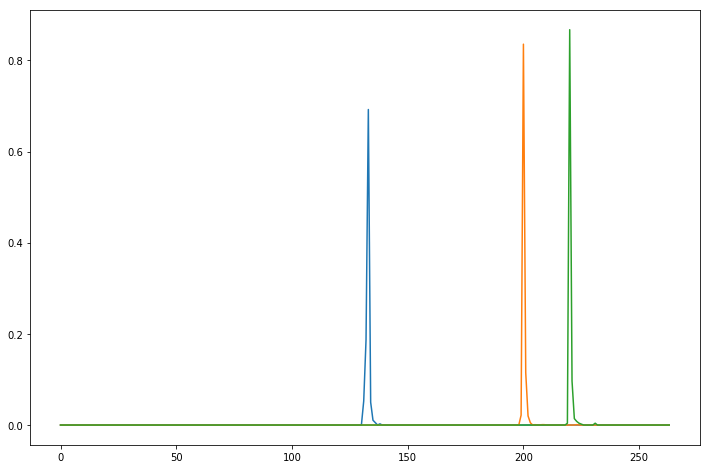

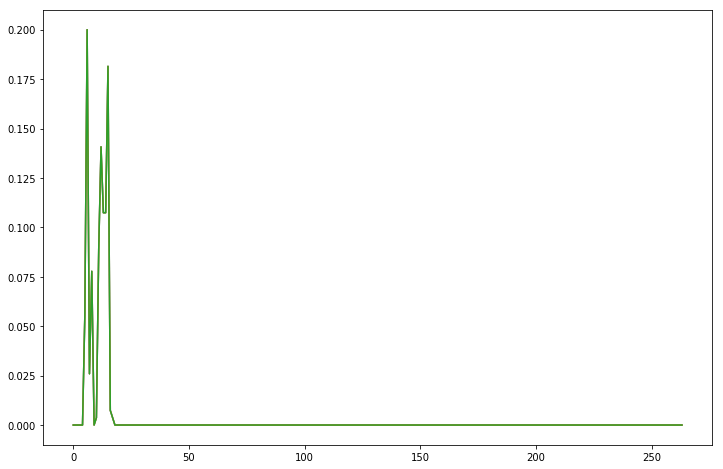

In [92]:
labeled_sample = sample_ic_pd
labeled_sample["label"] = labels
for i in range(len(set(labels))):
    plt.figure(figsize=(12, 8))
    which = labeled_sample.label == i
    labeled_sample[which].sample(n=3, replace=True).count_daily.map(lambda r: pd.Series(r).plot())

In [ ]:
def doKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    return clust_labels

clust_labels = doKmeans(wh1, 5)
kmeans = pd.DataFrame(clust_labels)